In [1]:
from __future__ import division
import numpy as np
from numpy import fft
from scipy import signal, ndimage, misc, fftpack
import bitarray
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import reedsolo

%matplotlib inline

In [2]:
IMG_DIR = 'Images/'

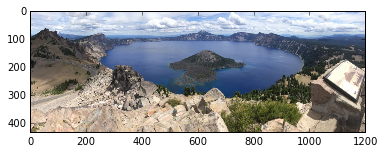

In [3]:
img = ndimage.imread(IMG_DIR+'createrLake.tiff')
plt.imshow(img)
plt.show()

In [4]:
def RGB2YCbCr(RGB):
    # Full range RGB/YCbCr conversion
    A = np.array([[[ 0.299,  0.587,  0.114],
                   [-0.169, -0.331,  0.500],
                   [ 0.500, -0.419, -0.081]]])
    
    YCbCr = np.dot(A, RGB.reshape((-1, 3)).T).T.reshape(RGB.shape) + np.array([0, 128, 128]).reshape((1,1,3))
    return YCbCr[:,:,0], YCbCr[:,:,1], YCbCr[:,:,2]

def YCbCr2RGB(y, cb, cr):
    # Full range RGB/YCbCr conversion
    B = np.array([[1.000,  0.000,  1.400],
                  [1.000, -0.343, -0.711],
                  [1.000,  1.765,  0.000]])
    
    YCbCr = np.dstack((y, cb-128, cr-128))
    return np.dot(B, YCbCr.reshape((-1, 3)).T).T.reshape(YCbCr.shape)

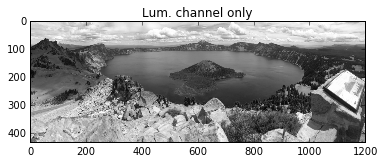

10.034 255.0


In [5]:
# Proof of concept of color space conversion
imgL, imgCb, imgCr = RGB2YCbCr(img)
plt.imshow(imgL, cmap='gray')
plt.title("Lum. channel only")
plt.show()

print np.min(imgL), np.max(imgL)

In [6]:
def genZigZag(n):
    # Used to calculate the "zigzag" traversal used to flatten JPEG blocks
    # Ascending
    swap = 0
    for idxSum in range(n):
        x = 0 if swap else idxSum
        y = idxSum if swap else 0
        if swap:
            while y >= 0:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= 0:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
    
    #Decending
    floor = 1
    for idxSum in range(n, 2*n-1):
        x = floor if swap else n-1
        y = n-1 if swap else floor
        if swap:
            while y >= floor:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= floor:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
        floor += 1

def DCT_2D(x):
    return fftpack.dct(fftpack.dct(x, norm='ortho', axis=0), norm='ortho', axis=1)

def IDCT_2D(x):
    return fftpack.idct(fftpack.idct(x, norm='ortho', axis=0), norm='ortho', axis=1)

def rescale(img):
    if np.min(img) < 0:
        img = img - np.min(img)
    if np.max(img) > 255:
        img = np.divide(img, np.max(img)) * 255
    return img

def clip(img, minval=0, maxval=255):
    return np.clip(img, minval, maxval, img)

def getLim(img):
    return (np.min(img), np.max(img))

def PSNR(im_truth, im_test, maxval=255.):
    mse = np.linalg.norm(im_truth.astype(np.float64) - im_test.astype(np.float64))**2 / np.prod(np.shape(im_truth))
    return 10 * np.log10(maxval**2 / mse)

def isGrayscale(img, THRESH=25.):
    return PSNR(img, np.dstack((img[:,:,0], img[:,:,0], img[:,:,0]))) > THRESH

In [7]:
class JPEGlib(object):
    # Standard-specified Luminosity Table
    QL = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
                   [12, 12, 14, 19,  26,  58,  60,  55],
                   [14, 13, 16, 24,  40,  57,  69,  56],
                   [14, 17, 22, 29,  51,  87,  80,  62],
                   [18, 22, 37, 56,  68, 109, 103,  77],
                   [24, 35, 55, 64,  81, 104, 113,  92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])
    
    # Standard-specified Chrominance Table
    QC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]])

    QN = np.ones((8,8))
    
    
    def __init__(self, raw, qtable, QF=50, dims=None, rescale=False):
        assert 1 <= QF < 100, "Quality Factor (QF) must be 1 <= QF < 100"
        if QF > 50:
            alpha = 2 - QF/50
        else:
            alpha = 50/QF
        
        self.raw = raw
        self.qtable = qtable*alpha
        self.dims = raw.shape if dims is None else dims
        self.zstride = list(genZigZag(8))
        self.linstride = list(range(64))
        self.rescale = rescale


class JPEG(JPEGlib):
    def __init__(self, raw, qtable, QF):
        super(JPEG, self).__init__(raw, qtable, QF)

    def process(self, inarr=None, dims=None):
        if inarr is None:
            inarr = self.raw
        if dims is None:
            dims = self.dims
        out = np.zeros(((dims[0]//8)*(dims[1]//8), 64))
        
        for i in xrange(0, dims[0], 8):
            for j in xrange(0, dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                block = DCT_2D(block)
                block = np.round(np.divide(block, self.qtable))
                for k, z in zip(self.linstride, self.zstride):
                    out[(dims[1]*i//64)+(j//8), k] = block[z[0], z[1]]
        return out

class IJPEG(JPEGlib):
    def __init__(self, raw, qtable, QF, dims, rescale=True):
        super(IJPEG, self).__init__(raw, qtable, QF, dims, rescale)

    def process(self, inarr=None, dims=None):
        if inarr is None:
            inarr = self.raw
        if dims is None:
            dims = self.dims
        out = np.zeros(self.dims)
        block = np.empty((8,8))

        for i in xrange(0, dims[0], 8):
            for j in xrange(0, dims[1], 8):
                for k, z in zip(self.linstride, self.zstride):
                    block[z[0], z[1]] = inarr[(dims[1]*i//64)+(j//8), k]
                block = np.multiply(block, self.qtable)
                block = IDCT_2D(block)
                out[i:i+8, j:j+8] = block

        return rescale(out) if self.rescale else out

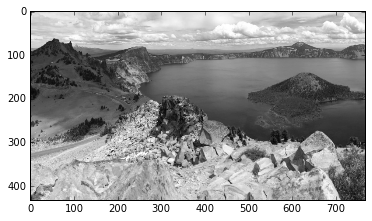

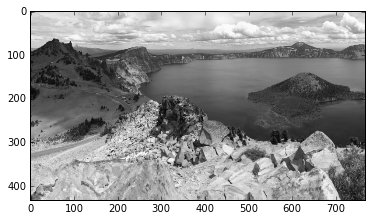

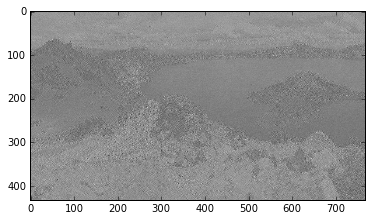

10.034 255.0
10.4188555238 255.0
124.0 1271.0
-390.0 494.0


In [8]:
# Proof of concept of JPEG class
imgIn = imgL[:520,:768]
j = JPEG(imgIn, qtable=JPEG.QL, QF=95)
imgProc = j.process()
jI = IJPEG(imgProc, JPEG.QL, QF=95, dims=imgIn.shape, rescale=True)
imgOut = jI.process()


plt.figure()
plt.imshow(imgIn, cmap='gray')
plt.figure()
plt.imshow(imgOut.astype(np.uint8), cmap='gray')
plt.figure()
plt.imshow(imgIn - imgOut, cmap='gray')
plt.show()

print np.min(imgIn), np.max(imgOut)
print np.min(imgOut), np.max(imgOut)
print np.min(imgProc[:,0]), np.max(imgProc[:,0])
print np.min(imgProc[:,1:]), np.max(imgProc[:,1:])

In [9]:
def RiFi_preprocess(img, quality):
    # Calculating image shape to be even multiples of 8.
    targetsize = img.shape[0] + (8 - (img.shape[0] % 8)) % 8, \
                 img.shape[1] + (8 - (img.shape[1] % 8)) % 8
    subsize = targetsize[0]//2, targetsize[1]//2                 # subsampling by 2x2
    subsize = subsize[0] + (8 - (subsize[0] % 8)) % 8, \
              subsize[1] + (8 - (subsize[1] % 8)) % 8
    
    # RGB -> YCbCr and subsampling (is it better to 0 pad instead?)
    imgY, imgCb, imgCr = RGB2YCbCr(img)
    imgY = signal.resample(signal.resample(imgY, targetsize[0], axis=0), targetsize[1], axis=1)
    imgCb = signal.resample(signal.resample(imgCb, subsize[0], axis=0), subsize[1], axis=1)
    imgCr = signal.resample(signal.resample(imgCr, subsize[0], axis=0), subsize[1], axis=1)
    
    # JPEG DCT transformation, quatization
    bitsY = JPEG(imgY, qtable=JPEGlib.QN, QF=quality).process()
    bitsCb = JPEG(imgCb, qtable=JPEGlib.QN, QF=quality).process()
    bitsCr = JPEG(imgCr, qtable=JPEGlib.QN, QF=quality).process()
    return targetsize, subsize, bitsY, bitsCb, bitsCr, getLim(img[:,:,0]), getLim(img[:,:,1]), getLim(img[:,:,2])
    
def RiFi_postprocess(bitsY, bitsCb, bitsCr, targetsize, subsize, originalsize, quality, Rlim, Glim, Blim):
    # Use JPEG class to convert bitarrays back to images
    imgY = IJPEG(bitsY, qtable=JPEGlib.QN, QF=quality, dims=targetsize).process()
    imgCb = IJPEG(bitsCb, qtable=JPEGlib.QN, QF=quality, dims=subsize).process()
    imgCr = IJPEG(bitsCr, qtable=JPEGlib.QN, QF=quality, dims=subsize).process()
    
    # Reconstruct RGB image in original dimensions
    imgY = signal.resample(signal.resample(imgY, originalsize[0], axis=0), originalsize[1], axis=1)
    imgCb = signal.resample(signal.resample(imgCb, originalsize[0], axis=0), originalsize[1], axis=1)
    imgCr = signal.resample(signal.resample(imgCr, originalsize[0], axis=0), originalsize[1], axis=1)
    imgRecon = YCbCr2RGB(imgY, imgCb, imgCr)

    # Rescale image and cast to uint8
    imgRecon[:,:,0] = clip(imgRecon[:,:,0], minval=Rlim[0], maxval=Rlim[1])
    imgRecon[:,:,1] = clip(imgRecon[:,:,1], minval=Glim[0], maxval=Glim[1])
    imgRecon[:,:,2] = clip(imgRecon[:,:,2], minval=Blim[0], maxval=Blim[1])
    return imgRecon.astype(np.uint8)

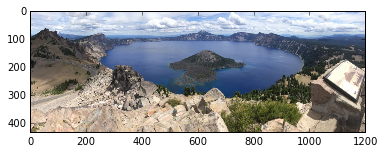

In [10]:
img = ndimage.imread(IMG_DIR+'createrLake.tiff')
plt.imshow(img)
plt.show()

In [11]:
print isGrayscale(img)

False


In [16]:
tsize, ssize, Y, Cb, Cr, Rlim, Glim, Blim = RiFi_preprocess(img, 50)

### TRANSMIT: img.shape[:2], tsize, ssize, Y, Cb, Cr ###

imgRecon = RiFi_postprocess(Y, Cb, Cr, tsize, ssize, (img.shape[0], img.shape[1]), 50, Rlim, Glim, Blim)

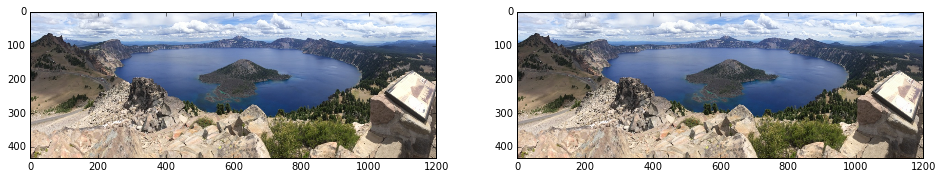

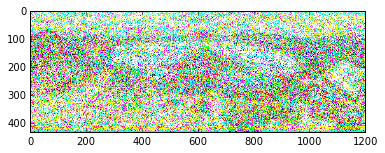

PSNR:  46.1595798634
(432L, 1200L, 3L)
(432L, 1200L, 3L)


In [17]:
width, height = plt.figaspect(0.25)
fig = plt.figure(figsize=(width,height))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(imgRecon)

plt.figure()
plt.imshow(img.astype(np.float64) - imgRecon.astype(np.float64))
plt.show()

print 'PSNR: ', PSNR(img, imgRecon)
print img.shape
print imgRecon.shape

In [18]:
misc.imsave(IMG_DIR+'craterLake_reconstructed.jpg', imgRecon)

In [108]:
import Encoding
import Transmission
reload(Encoding)
reload(Transmission)

print 
e = Encoding.encode(Y, Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
a = len(e)
# _ = Transmission.testTransmit(e)

e = Encoding.encode(Cb, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
b = len(e)
# Transmission.testTransmit(e)

e = Encoding.encode(Cr, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
c = len(e)
# Transmission.testTransmit(e)

print (a+b+c)//8
print img.shape[0]*img.shape[1]*3


207437
1555200


In [235]:
reload(Transmission)
reload(Encoding)
rs = reedsolo.RSCodec(30)
e = Encoding.encode(Cr[:10], Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
p = Transmission.packetize(e,rs)
f = Transmission.findPackets(Transmission.NRZI2NRZ(p), rs)

AttributeError: 'list' object has no attribute 'copy'

In [233]:
print e
print f

bitarray('000110110001111111110100100000001001010010011111010101111111011111111111110000011111111010011010100010110101101110110111111101111111111101011111110101101001011001111101111111110001011111111110011111111101000110101111011111111100010111111111100111111111010010011100101001111101110111111101111011111111110011111111101010011110011110010111011101111111011110111111111100111111111010010011101010010011011111110110100111111101111011111111110011111111101011001001010101011001111011111100110011111110111101111111111001111111110101110100110001100111001110110111001101110011001111111011110111111111100111111111010101011100111100110111101111001001111111011110111111111100111111111010')
[bitarray('0001101100011111111101001000000010010100100111110101011111110111111111111100000111111110100110101000101101011011101101111111011111111111010111111101011010010110011111011111111100010111111111100111111111010001101011110111111111000101111111111001111111110100100111001010011111011101111111011110111111111100

In [207]:
def magic():
    MIN_DIMS = 6000
    
    img1 = ndimage.imread('im1.bmp')
    if img1.shape[0]*img1.shape[2] < MIN_DIMS:
        # send with no processing [Flag 0]
    elif isGrayscale(img1):
        # send only Y channel w/ JPEG[Flag 1]
    else:
        # use JPEG compression
        

IndentationError: expected an indented block (<ipython-input-207-8e555218b431>, line 7)